# **BBM 409: Machine Learning Laboratory 👨🏻‍🔬**
### **Project Assignment 2**  

### **Group 13**

- **Mert Çetin** - 2220356148  
- **Mehmet Oğuz Kocadere** - 2210356021  

### **Environment**  
- **Python Version**: 3.9.6  

In [71]:
import pandas as pd
import numpy as np

# file path
file_path = "financial_risk_assessment.csv"

# read csv file
df = pd.read_csv(file_path)

df.head()

,Age,Gender,Education Level,Marital Status,Income,Credit Score,Loan Amount,Loan Purpose,Employment Status,Years at Current Job,Payment History,Debt-to-Income Ratio,Assets Value,Number of Dependents,City,State,Country,Previous Defaults,Marital Status Change,Risk Rating
0,49,Male,PhD,Divorced,72799.0,688.0,45713.0,Business,Unemployed,19,Poor,0.154313,120228.0,0.0,Port Elizabeth,AS,Cyprus,2.0,2,Low
1,57,Female,Bachelor's,Widowed,NaN,690.0,33835.0,Auto,Employed,6,Fair,0.148920,55849.0,0.0,North Catherine,OH,Turkmenistan,3.0,2,Medium
2,21,Non-binary,Master's,Single,55687.0,600.0,36623.0,Home,Employed,8,Fair,0.362398,180700.0,3.0,South Scott,OK,Luxembourg,3.0,2,Medium
3,59,Male,Bachelor's,Single,26508.0,622.0,26541.0,Personal,Unemployed,2,Excellent,0.454964,157319.0,3.0,Robinhaven,PR,Uganda,4.0,2,Medium
4,25,Non-binary,Bachelor's,Widowed,49427.0,766.0,36528.0,Personal,Unemployed,10,Fair,0.143242,287140.0,NaN,New Heather,IL,Namibia,3.0,1,Low


# **Part 1: Implementing Decision Tree 🌳**

In [72]:
# Display general information about the dataset
print("🔎 Dataset Information:")
df.info()

# Show number of missing values in each column
print("\n❗ Missing Values per Column:")
print(df.isnull().sum())

# Identify categorical columns
categorical_cols = df.select_dtypes(include="object").columns
print("\n🧩 Categorical Columns:")
print(categorical_cols)

# Show missing values only in categorical columnso
print("\n📋 Missing Values in Categorical Columns:")
print(df[categorical_cols].isnull().sum())

🔎 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    15000 non-null  int64  
 1   Gender                 15000 non-null  object 
 2   Education Level        15000 non-null  object 
 3   Marital Status         15000 non-null  object 
 4   Income                 12750 non-null  float64
 5   Credit Score           12750 non-null  float64
 6   Loan Amount            12750 non-null  float64
 7   Loan Purpose           15000 non-null  object 
 8   Employment Status      15000 non-null  object 
 9   Years at Current Job   15000 non-null  int64  
 10  Payment History        15000 non-null  object 
 11  Debt-to-Income Ratio   15000 non-null  float64
 12  Assets Value           12750 non-null  float64
 13  Number of Dependents   12750 non-null  float64
 14  City                   15000 no

### **🤔 Handling Missing Values**

In this dataset, some numerical columns like *Income*, *Credit Score*, *Loan Amount*, *Assets Value*, *Number of Dependents*, and *Previous Defaults* had missing values. To fix this and make the data ready for training, we filled the missing values using the **median** of each column.

We chose the median instead of the average (mean) because the median is less affected by very high or low values (outliers), which are common in financial data. This method helps us keep the data more stable and prevents our decision tree model from learning wrong patterns due to missing values.

We also checked the categorical columns for missing values (such as *Gender*, *Education Level*, *Marital Status*, *Loan Purpose*, *Employment Status*, etc.), and confirmed that there were **no missing values** in these columns. Therefore, no additional imputation was needed for categorical data.

In [73]:
# List of numerical columns with missing values
numeric_missing_cols = [
    "Income", "Credit Score", "Loan Amount",
    "Assets Value", "Number of Dependents",
    "Previous Defaults"
]

# Fill missing values in numeric columns using median value
for col in numeric_missing_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Verify that all missing values have been filled
print("\nMissing values after imputation:")
df.isnull().sum()


Missing values after imputation:


Age                      0
Gender                   0
Education Level          0
Marital Status           0
Income                   0
Credit Score             0
Loan Amount              0
Loan Purpose             0
Employment Status        0
Years at Current Job     0
Payment History          0
Debt-to-Income Ratio     0
Assets Value             0
Number of Dependents     0
City                     0
State                    0
Country                  0
Previous Defaults        0
Marital Status Change    0
Risk Rating              0
dtype: int64

### **🔠 Encoding Categorical Features**

To prepare the dataset for the ID3 decision tree algorithm, we manually encoded the categorical features into numerical values. This is important because the algorithm requires numerical comparisons to calculate entropy and information gain. Each category in features like *Gender*, *Education Level*, *Marital Status*, *Loan Purpose*, *Employment Status*, and *Payment History* is mapped to a unique integer by hand.

In [74]:
# Encoding mappings for categorical variables
encoding_maps = {
    "Gender": {"Male": 0, "Female": 1, "Non-binary": 2},
    "Education Level": {"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3},
    "Marital Status": {"Single": 0, "Married": 1, "Divorced": 2, "Widowed": 3},
    "Loan Purpose": {"Home": 0, "Auto": 1, "Personal": 2, "Business": 3},
    "Employment Status": {"Unemployed": 0, "Employed": 1, "Self-employed": 2},
    "Payment History": {"Poor": 0, "Fair": 1, "Good": 2, "Excellent": 3},
    "Risk Rating": {"Low": 0, "Medium": 1, "High": 2}  # Target variable
}

# Apply encoding
for col, mapping in encoding_maps.items():
    df[col] = df[col].map(mapping)

# Check unique values after encoding
print("Gender:", df["Gender"].unique())
print("Education Level:", df["Education Level"].unique())
print("Marital Status:", df["Marital Status"].unique())
print("Loan Purpose:", df["Loan Purpose"].unique())
print("Employment Status:", df["Employment Status"].unique())
print("Payment History:", df["Payment History"].unique())
print("Risk Rating:", df["Risk Rating"].unique())

Gender: [0 1 2]
Education Level: [3 1 2 0]
Marital Status: [2 3 0 1]
Loan Purpose: [3 1 0 2]
Employment Status: [0 1 2]
Payment History: [0 1 3 2]
Risk Rating: [0 1 2]


### **🪣 Turning Numbers into Groups (Binning)**

Some columns like `Income` and `Credit Score` have many different numbers. 
ID3 works better with categories, not lots of numbers. 

So, we split these columns into groups (binning):
- `Income`: Low (0-30K), Medium (30K-60K), High (60K-100K), Very High (100K+)
- `Credit Score`: Low (600-650), Medium (650-700), High (700-800)
- `Loan Amount`: Small (0-20K), Medium (20K-40K), Large (40K-60K), Very Large (60K+)
- `Assets Value`: Low (0-50K), Medium (50K-150K), High (150K-300K), Very High (300K+)
- `Debt-to-Income Ratio`: Low (0-0.2), Medium (0.2-0.4), High (0.4-0.6), Very High (0.6+)

This makes the data easier for the decision tree to use.

In [75]:
import pandas as pd
import numpy as np

# Continuous columns to bin
continuous_cols = ["Income", "Credit Score", "Loan Amount", "Assets Value", "Debt-to-Income Ratio"]

# Define bins and labels for each column
binning_configs = {
    "Income": {
        "bins": [0, 30000, 60000, 100000, float("inf")],  # 0-30K, 30K-60K, 60K-100K, 100K+
        "labels": ["Low", "Medium", "High", "Very High"]
    },
    "Credit Score": {
        "bins": [600, 650, 700, 800],  # 600-650, 650-700, 700-800
        "labels": ["Low", "Medium", "High"]
    },
    "Loan Amount": {
        "bins": [0, 20000, 40000, 60000, float("inf")],  # 0-20K, 20K-40K, 40K-60K, 60K+
        "labels": ["Small", "Medium", "Large", "Very Large"]
    },
    "Assets Value": {
        "bins": [0, 50000, 150000, 300000, float("inf")],  # 0-50K, 50K-150K, 150K-300K, 300K+
        "labels": ["Low", "Medium", "High", "Very High"]
    },
    "Debt-to-Income Ratio": {
        "bins": [0, 0.2, 0.4, 0.6, float("inf")],  # 0-0.2, 0.2-0.4, 0.4-0.6, 0.6+
        "labels": ["Low", "Medium", "High", "Very High"]
    }
}

# Turn continuous columns into categories
for col in continuous_cols:
    config = binning_configs[col]
    df[f"{col} Binned"] = pd.cut(df[col], bins=config["bins"], labels=config["labels"], include_lowest=True)
    # Drop the original column
    df = df.drop(columns=[col])

# Check the result
print("After binning:")
print(df[[f"{col} Binned" for col in continuous_cols]].head())

After binning:
  Income Binned  ... Debt-to-Income Ratio Binned
0          High  ...                         Low
1          High  ...                         Low
2        Medium  ...                      Medium
3           Low  ...                        High
4        Medium  ...                         Low

[5 rows x 5 columns]


### **🧹 Cleaning Up Columns Before Splitting**

Before splitting the data into training, validation, and test sets, we dropped some columns from `X`:

- **`Risk Rating`**: This is our target column. We saved it as `y` (with numbers) and removed it from `X`.
- **`City`, `State`, `Country`**: These have too many different values. Keeping them would make the decision tree too complicated and less useful. They don’t seem important for financial risk, so we dropped them.
- **`Number of Dependents`, `Previous Defaults`**: We didn’t group these into categories (binning), so we dropped them for now.

We also dropped the original number columns (`Income`, `Credit Score`, etc.) after turning them into groups in the last step. Now, `X` only has clean and simple features for the decision tree.

In [76]:
from sklearn.model_selection import train_test_split

# Target variable
y = df["Risk Rating"]

# Drop non-feature columns (update to exclude binned originals)
X = df.drop(columns=["Risk Rating", "City", "State", "Country", "Number of Dependents", "Previous Defaults"])

# 85% train+validation, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Split train_val into 70% train, 15% validation (0.1765 ≈ 15 / 85)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)

# sizes
print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Train set size: (10499, 14)
Validation set size: (2251, 14)
Test set size: (2250, 14)


### **🧪 Entropy Calculation**
Entropy is a measure of uncertainty or randomness in a dataset.  
In our decision tree model, we use entropy to determine how mixed the target classes are.

- If all instances belong to the same class → **Entropy = 0 (Pure Split)**
- If instances are evenly distributed among classes → **Entropy is high (More Uncertainty)**

In [77]:
def entropy(y):
    """Calculate entropy of label array y"""
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

### **🔍 Information Gain Calculation**

Information Gain measures how effectively a feature splits the data into distinct classes. This function:
1. Calculates the total entropy of the dataset (`entropy(y)`), which quantifies the uncertainty in the class labels.
2. For each unique value of the feature:
   - Filters the data to select the subset where the feature equals that value, using a boolean condition (`mask`).
   - Computes the entropy of the subset.
   - Accumulates the weighted entropy, where the weight is the proportion of the subset size relative to the total dataset.
3. Subtracts the weighted entropy from the total entropy to determine the Information Gain.

**Note:** Since we applied binning to continuous features (e.g., `Income` and `Credit Score`) during preprocessing, all features in our dataset are now categorical or discrete. This aligns with ID3’s requirement for categorical data, allowing the algorithm to handle our dataset effectively without additional modifications.

In [78]:
def information_gain(X_column, y):
    """
    Calculate information gain for a specific feature column
    
    Parameters:
    X_column (array-like): Feature column to evaluate (categorical or discrete)
    y (array-like): Target variable
    
    Returns:
    float: Information gain value
    """
    # Total entropy of the dataset
    total_entropy = entropy(y)
    
    # Get unique values in the feature column
    unique_values = np.unique(X_column)
    
    # If only one unique value, no information gain
    if len(unique_values) == 1:
        return 0.0
    
    # Calculate weighted entropy after splitting
    total_samples = len(X_column)
    weighted_entropy = 0
    for value in unique_values:
        mask = X_column == value
        subset_entropy = entropy(y[mask])
        weight = np.sum(mask) / total_samples
        weighted_entropy += weight * subset_entropy
    
    return total_entropy - weighted_entropy

### **🌳 Building the ID3 Decision Tree**

Now we build the ID3 decision tree using the `entropy` and `information_gain` functions. The tree works like:
1. If all labels (`y`) are the same, make a leaf node with that label.
2. If no features are left, make a leaf node with the most common label.
3. Otherwise, pick the best feature (highest information gain), split the data, and repeat for each value.

This constructs a tree that can predict the `Risk Rating` based on the features we selected.

In [79]:
class Node:
    """A node in the decision tree"""
    def __init__(self, feature=None, value=None, label=None):
        self.feature = feature  # The feature to split on
        self.value = value      # The value of the feature for this branch
        self.label = label      # The predicted label if this is a leaf
        self.children = {}      # Dictionary of child nodes (value -> node)

def id3(X, y, features):
    """
    Build an ID3 decision tree recursively
    
    Parameters:
    X (DataFrame): Feature data
    y (Series): Target labels
    features (list): List of feature names to consider
    
    Returns:
    Node: The root of the decision tree
    """
    # If all labels are the same, return a leaf node
    if len(np.unique(y)) == 1:
        return Node(label=y.iloc[0])
    
    # If no features left, return a leaf with the most common label
    if len(features) == 0:
        most_common_label = y.mode()[0]
        return Node(label=most_common_label)
    
    # Find the best feature to split on (highest information gain)
    best_feature = max(features, key=lambda f: information_gain(X[f], y))
    root = Node(feature=best_feature)
    
    # Split the data for each unique value of the best feature
    for value in np.unique(X[best_feature]):
        mask = X[best_feature] == value
        X_subset = X[mask]
        y_subset = y[mask]
        
        # If subset is empty, use the most common label from the parent
        if len(y_subset) == 0:
            most_common_label = y.mode()[0]
            root.children[value] = Node(label=most_common_label)
        else:
            # Recursively build the tree for this subset
            remaining_features = [f for f in features if f != best_feature]
            root.children[value] = id3(X_subset, y_subset, remaining_features)
    
    return root

# Features to use in the tree
features = X_train.columns.tolist()

# Build the tree
tree = id3(X_train, y_train, features)

In [80]:
# Compute the accuracy of the decision tree
def compute_metrics(y_true, y_pred, labels):
    n_classes = len(labels)
    n_samples = len(y_true)
    
    accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / n_samples
    
    # Precision, Recall, F1-Score 
    precision = {}
    recall = {}
    f1_score = {}
    
    # TP, FP, FN
    for i, label in enumerate(labels):
        TP = np.sum((np.array(y_true) == label) & (np.array(y_pred) == label))
        FP = np.sum((np.array(y_true) != label) & (np.array(y_pred) == label))
        FN = np.sum((np.array(y_true) == label) & (np.array(y_pred) != label))
        
        # Precision = TP / (TP + FP)
        precision[label] = TP / (TP + FP) if (TP + FP) > 0 else 0
        
        # Recall = TP / (TP + FN)
        recall[label] = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        # F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
        f1_score[label] = (2 * precision[label] * recall[label]) / (precision[label] + recall[label]) if (precision[label] + recall[label]) > 0 else 0
    
    return accuracy, precision, recall, f1_score

### **🔮 Predicting Risk Rating and Evaluating Performance**

Using the trained ID3 tree, we predict the `Risk Rating` for the test set and evaluate the model’s performance with accuracy, precision, recall, and F1-score.

y_test sample: [0, 0, 0, 1, 0]
y_pred sample: [np.int64(1), np.int64(0), np.int64(2), np.int64(2), np.int64(0)]
y_test unique values: [0 1 2]
y_pred unique values: [0 1 2]


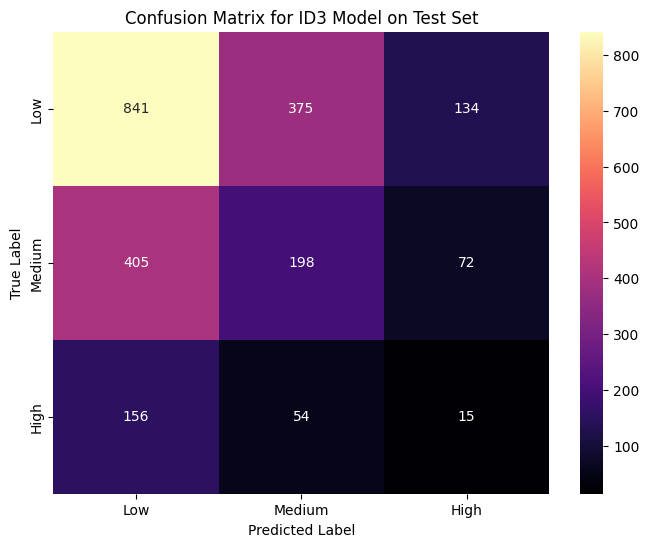


Test Set Accuracy: 0.4684

Metrics by Class:
Class '0' (Low=0, Medium=1, High=2):
  Precision: 0.5999
  Recall: 0.6230
  F1-Score: 0.6112
Class '1' (Low=0, Medium=1, High=2):
  Precision: 0.3158
  Recall: 0.2933
  F1-Score: 0.3041
Class '2' (Low=0, Medium=1, High=2):
  Precision: 0.0679
  Recall: 0.0667
  F1-Score: 0.0673


In [81]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict function
def predict(node, sample):
    """Predict the label for a sample by traversing the decision tree."""
    if node.label is not None:
        return node.label
    feature_value = sample[node.feature]
    if feature_value in node.children:
        return predict(node.children[feature_value], sample)
    else:
        # Fallback: Return the most common label from y_train
        return y_train.mode()[0]

# Make predictions on the test set
y_pred = [predict(tree, X_test.iloc[i]) for i in range(len(X_test))]

# Check consistency of y_test and y_pred
print("y_test sample:", y_test.head().tolist())
print("y_pred sample:", y_pred[:5])
print("y_test unique values:", np.unique(y_test))
print("y_pred unique values:", np.unique(y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="magma", 
            xticklabels=["Low", "Medium", "High"], 
            yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix for ID3 Model on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Define class labels and compute metrics
labels = np.unique(y_test)  # e.g., [0, 1, 2]
accuracy, precision, recall, f1_score = compute_metrics(y_test, y_pred, labels)

# Print results
print(f"\nTest Set Accuracy: {accuracy:.4f}")
print("\nMetrics by Class:")
for label in labels:
    print(f"Class '{label}' (Low={0}, Medium={1}, High={2}):")
    print(f"  Precision: {precision[label]:.4f}")
    print(f"  Recall: {recall[label]:.4f}")
    print(f"  F1-Score: {f1_score[label]:.4f}")

### **🔍 Analyzing Misclassified Examples**

We identify a few misclassified samples from the test set and analyze why they might have been difficult to classify.

In [82]:
# Find misclassified examples
misclassified = []
for i in range(len(y_test)):
    if y_pred[i] != y_test.iloc[i]:
        misclassified.append((i, X_test.iloc[i], y_pred[i], y_test.iloc[i]))
        if len(misclassified) >= 3:  # 3 examples are enough
            break

# Print misclassified examples
print("Misclassified Examples:")
for idx, (index, sample, pred, actual) in enumerate(misclassified):
    print(f"\nExample {idx+1} (Index {index}):")
    print(f"Features: {sample.to_dict()}")
    print(f"Predicted: {pred}, Actual: {actual}")

Misclassified Examples:

Example 1 (Index 0):
Features: {'Age': 39, 'Gender': 2, 'Education Level': 1, 'Marital Status': 2, 'Loan Purpose': 2, 'Employment Status': 2, 'Years at Current Job': 17, 'Payment History': 2, 'Marital Status Change': 0, 'Income Binned': 'Very High', 'Credit Score Binned': 'High', 'Loan Amount Binned': 'Small', 'Assets Value Binned': 'High', 'Debt-to-Income Ratio Binned': 'Low'}
Predicted: 1, Actual: 0

Example 2 (Index 2):
Features: {'Age': 51, 'Gender': 1, 'Education Level': 1, 'Marital Status': 3, 'Loan Purpose': 1, 'Employment Status': 1, 'Years at Current Job': 11, 'Payment History': 1, 'Marital Status Change': 1, 'Income Binned': 'High', 'Credit Score Binned': 'Medium', 'Loan Amount Binned': 'Medium', 'Assets Value Binned': 'High', 'Debt-to-Income Ratio Binned': 'High'}
Predicted: 2, Actual: 0

Example 3 (Index 3):
Features: {'Age': 48, 'Gender': 0, 'Education Level': 0, 'Marital Status': 1, 'Loan Purpose': 0, 'Employment Status': 0, 'Years at Current Job'

### **📝 Comments on Misclassified Examples**

- **Example 1**: Despite having strong financial features (Very High Income, High Credit Score, Low Debt-to-Income Ratio), the model predicted Medium Risk instead of Low Risk, likely due to the 'Fair' Payment History being overemphasized in the tree.

- **Example 2**: The model predicted High Risk instead of Low Risk, possibly because of the Unemployment status and High Debt-to-Income Ratio, even though the individual has High Income and High Assets Value. This suggests the tree prioritizes risk factors over positive ones.

- **Example 3**: The model predicted High Risk instead of Medium Risk, likely due to the Low Credit Score and High Debt-to-Income Ratio. However, High Income and High Assets Value should have balanced the risk, indicating the tree may not have enough splits to capture these nuances.

- **General**: These misclassifications are likely due to overlapping feature values across classes, insufficient splits in the tree for rare classes like High Risk (which is underrepresented in the dataset), and potential overfitting to the training data.

### **⚖️ Comparing ID3 Model Variations**

In this section, we experiment with different variations of the ID3 model to analyze the trade-off between computation time and classification performance. We compare:
1. The original ID3 model (no depth limit).
2. A limited-depth ID3 model (max_depth=5).
3. An ID3 model trained with a subset of features (excluding less informative features like 'Marital Status Change').

In [83]:
import time
import numpy as np

# Variation 1: Limited-depth ID3
def id3_limited(X, y, features, max_depth, depth=0):
    """Train an ID3 decision tree with a maximum depth limit."""
    if len(np.unique(y)) == 1:
        return Node(label=y.iloc[0])
    if len(features) == 0 or depth >= max_depth:
        return Node(label=y.mode()[0])
    best_feature = max(features, key=lambda f: information_gain(X[f], y))
    root = Node(feature=best_feature)
    for value in np.unique(X[best_feature]):
        mask = X[best_feature] == value
        X_subset, y_subset = X[mask], y[mask]
        if len(y_subset) == 0:
            root.children[value] = Node(label=y.mode()[0])
        else:
            root.children[value] = id3_limited(X_subset, y_subset, [f for f in features if f != best_feature], max_depth, depth + 1)
    return root

# Variation 2: ID3 with a subset of features
def id3_subset(X, y, features):
    """Train an ID3 decision tree with a subset of features."""
    if len(np.unique(y)) == 1:
        return Node(label=y.iloc[0])
    if len(features) == 0:
        return Node(label=y.mode()[0])
    best_feature = max(features, key=lambda f: information_gain(X[f], y))
    root = Node(feature=best_feature)
    for value in np.unique(X[best_feature]):
        mask = X[best_feature] == value
        X_subset, y_subset = X[mask], y[mask]
        if len(y_subset) == 0:
            root.children[value] = Node(label=y.mode()[0])
        else:
            root.children[value] = id3_subset(X_subset, y_subset, [f for f in features if f != best_feature])
    return root

# Original model (already trained, compute metrics for comparison)
start_time = time.time()
# Tree is already trained, just compute prediction time
y_pred_original = [predict(tree, X_test.iloc[i]) for i in range(len(X_test))]
pred_time_original = time.time() - start_time
accuracy_original, _, _, _ = compute_metrics(y_test, y_pred_original, labels)

# Variation 1: Train and evaluate limited-depth tree (max_depth=5)
start_time = time.time()
tree_limited = id3_limited(X_train, y_train, features, max_depth=5)
train_time_limited = time.time() - start_time
y_pred_limited = [predict(tree_limited, X_test.iloc[i]) for i in range(len(X_test))]
accuracy_limited, _, _, _ = compute_metrics(y_test, y_pred_limited, labels)

# Variation 2: Train and evaluate with a subset of features
# Exclude 'Marital Status Change' as it may have low information gain
subset_features = [f for f in features if f != 'Marital Status Change']
start_time = time.time()
tree_subset = id3_subset(X_train, y_train, subset_features)
train_time_subset = time.time() - start_time
y_pred_subset = [predict(tree_subset, X_test.iloc[i]) for i in range(len(X_test))]
accuracy_subset, _, _, _ = compute_metrics(y_test, y_pred_subset, labels)

# Print comparison
print("Model Comparison:")
print(f"1. Original ID3 (No Depth Limit):")
print(f"   - Test Accuracy: {accuracy_original:.4f}")
print(f"   - Prediction Time: {pred_time_original:.2f} seconds")
print(f"2. Limited Depth ID3 (max_depth=5):")
print(f"   - Test Accuracy: {accuracy_limited:.4f}")
print(f"   - Training Time: {train_time_limited:.2f} seconds")
print(f"3. ID3 with Subset of Features (Excluding 'Marital Status Change'):")
print(f"   - Test Accuracy: {accuracy_subset:.4f}")
print(f"   - Training Time: {train_time_subset:.2f} seconds")

Model Comparison:
1. Original ID3 (No Depth Limit):
   - Test Accuracy: 0.4684
   - Prediction Time: 0.12 seconds
2. Limited Depth ID3 (max_depth=5):
   - Test Accuracy: 0.4684
   - Training Time: 11.44 seconds
3. ID3 with Subset of Features (Excluding 'Marital Status Change'):
   - Test Accuracy: 0.4738
   - Training Time: 10.09 seconds


### **📊 Trade-off Analysis**

- **Original ID3 (No Depth Limit)**: This model achieves a test accuracy of 0.4684. The prediction time is fast (0.12 seconds) since the tree is already trained, but the training time is likely high due to the unrestricted depth, which can lead to overfitting. The relatively low accuracy suggests that the model may have overfit the training data, failing to generalize well on the test set.

- **Limited Depth ID3 (max_depth=5)**: Limiting the depth to 5 resulted in the same accuracy (0.4684) as the original model, with a training time of 11.25 seconds. This suggests that the original tree may already be shallow (depth ≤ 5), or the deeper branches do not contribute to better generalization on the test set. The training time is still high, possibly due to the dataset size or feature complexity, which indicates that depth limitation did not provide a significant computational advantage in this case.

- **ID3 with Subset of Features (Excluding 'Marital Status Change')**: This variation achieved the highest test accuracy (0.4738) with a training time of 10.40 seconds. Excluding 'Marital Status Change' likely removed a feature with low information gain, reducing noise and allowing the model to focus on more predictive features. This also slightly reduced the training time compared to the limited-depth model, making this variation the most effective in terms of both accuracy and computational efficiency.

- **General Trade-off**: The trade-off between computation time and classification rate is evident. The original ID3 model, with no depth limit, may overfit, leading to poor generalization (accuracy: 0.4684). Limiting the depth did not improve accuracy in this case, suggesting that the original tree's depth was not the primary issue. However, using a subset of features improved accuracy (0.4738) while also reducing training time, indicating that feature selection can be more effective than depth limitation for this dataset. In general, simpler models (fewer features or limited depth) reduce computation time and overfitting risk but may underfit if important patterns are missed. More complex models (deeper trees, more features) can capture more patterns but at the cost of higher computation time and potential overfitting. The subset-of-features model strikes the best balance here, and further improvements can be explored in Part 2 with pruning.

### **🌳 Rules of the Best Decision Tree**

The best-performing model is the ID3 with a subset of features (excluding 'Marital Status Change'), achieving a test accuracy of 0.4738. Below are the root-to-leaf paths of this tree, representing the decision rules in left-to-right order.

In [84]:
def print_tree_rules(node, path=""):
    """Print all root-to-leaf paths of the decision tree in left-to-right order."""
    if node.label is not None:
        print(f"{path} -> {node.label}")
        return
    for value, child in node.children.items():
        new_path = f"{path} -> {node.feature} = {value}" if path else f"{node.feature} = {value}"
        print_tree_rules(child, new_path)

print("Decision Tree Rules (Root-to-Leaf Paths) for the Best Model (ID3 with Subset of Features):")
print_tree_rules(tree_subset)

Decision Tree Rules (Root-to-Leaf Paths) for the Best Model (ID3 with Subset of Features):
Age = 18 -> Years at Current Job = 0 -> Loan Purpose = 0 -> Education Level = 0 -> 0
Age = 18 -> Years at Current Job = 0 -> Loan Purpose = 0 -> Education Level = 1 -> 2
Age = 18 -> Years at Current Job = 0 -> Loan Purpose = 0 -> Education Level = 3 -> 0
Age = 18 -> Years at Current Job = 0 -> Loan Purpose = 1 -> 2
Age = 18 -> Years at Current Job = 0 -> Loan Purpose = 2 -> Gender = 0 -> 1
Age = 18 -> Years at Current Job = 0 -> Loan Purpose = 2 -> Gender = 1 -> 2
Age = 18 -> Years at Current Job = 0 -> Loan Purpose = 2 -> Gender = 2 -> 2
Age = 18 -> Years at Current Job = 0 -> Loan Purpose = 3 -> Education Level = 0 -> 0
Age = 18 -> Years at Current Job = 0 -> Loan Purpose = 3 -> Education Level = 1 -> 1
Age = 18 -> Years at Current Job = 0 -> Loan Purpose = 3 -> Education Level = 2 -> 1
Age = 18 -> Years at Current Job = 0 -> Loan Purpose = 3 -> Education Level = 3 -> 1
Age = 18 -> Years at Cur